# Only for LSTM plotting
This notebook is only for LSTM training; everytime using different model

In [27]:
import json
import os
import os.path as osp
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm

if "__file__" in globals():
    os.chdir(os.path.dirname(__file__) + "/..")
elif "pkg" not in os.listdir("."):
    os.chdir("..")

sys.path.append(".")

from pkg.helper import patt_corr, rmse
from pkg.utils.misc import savefig

%matplotlib inline

In [22]:
root_folder = "/grad/yli678/workspace/smoother_sampling/output/"
model = "L96"
foldername = "/Two_layer_L96_final/n_steps=500001,dim_I=40,sparse_obs=True,f=4.0,h=2.0,b=2.0,c=2.0,sigma_obs=1.0,sigma_u=1.0,sigma_v=1.0"
output_path = root_folder + foldername

In [4]:
json_filename = output_path + "/config.json"
with open(json_filename, "r") as f:
    configs = json.loads(f.read())

n_steps = configs["n_steps"]
dt = configs["dt"]
dim_I = configs["dim_I"]
dim_J = configs["dim_J"]

data_sampling = np.load(output_path + "/sampling.npz")
model_prediction_data = np.load(output_path + "/dynamicalmodels.npz")

true_state = data_sampling["true_state"][:, :dim_I]
pred_dt = model_prediction_data["pred_dt"]
obs_dt = model_prediction_data["obs_dt"]
pred_start_time = model_prediction_data["pred_start_time"]
pred_total_time = model_prediction_data["pred_total_time"]
last_lead_t = model_prediction_data["last_lead_t"]
pred_num_ensembles = model_prediction_data["pred_num_ensembles"]
predict_mean = model_prediction_data["predict_mean"]
predict_wrong_SPEKF = model_prediction_data["predict_wrong"]
rmse_perfect = model_prediction_data["rmse_perfect"]
rmse_wrong_SPEKF = model_prediction_data["rmse_wrong"]
corr_perfect = model_prediction_data["corr_perfect"]
corr_wrong_SPEKF = model_prediction_data["corr_wrong"]
predict_mean_DA = model_prediction_data["predict_mean_DA"]
predict_wrong_SPEKF_DA = model_prediction_data["predict_wrong_DA"]
rmse_perfect_DA = model_prediction_data["rmse_perfect_DA"]
rmse_wrong_SPEKF_DA = model_prediction_data["rmse_wrong_DA"]
corr_perfect_DA = model_prediction_data["corr_perfect_DA"]
corr_wrong_SPEKF_DA = model_prediction_data["corr_wrong_DA"]

model_dim = true_state.shape[1]
pred_n_steps = int(dt * (n_steps - 1) / pred_dt) + 1
pred_K = int(pred_dt / dt)

t = np.linspace(0, (n_steps - 1) * dt, n_steps)
t_pred = np.linspace(0, (pred_n_steps - 1) * pred_dt, pred_n_steps)
pred_idx = np.linspace(0, int((pred_n_steps - 1)) * pred_K, pred_n_steps)
pred_idx = pred_idx.astype(int)

obs_n_steps = int(dt * (n_steps - 1) / obs_dt) + 1
pred_obs_n_steps = int(obs_dt * (obs_n_steps - 1) / pred_dt) + 1
pred_obs_K = int(pred_dt / obs_dt)

pred_obs_idx = np.linspace(
    0, int((pred_obs_n_steps - 1)) * pred_obs_K, pred_obs_n_steps
)
pred_obs_idx = pred_obs_idx.astype(int)


lead_step = pred_K
pred_start_pred_step = int(pred_start_time / pred_dt)
pred_total_pred_steps = int(pred_total_time / pred_dt) + 1
lead_time_steps = np.linspace(
    0, last_lead_t, int(last_lead_t / lead_step) + 1
).astype(int)

t_target = t[pred_idx][
    pred_start_pred_step : pred_start_pred_step + pred_total_pred_steps
]
target = np.real(true_state)[pred_idx][
    pred_start_pred_step : pred_start_pred_step + pred_total_pred_steps
]

In [5]:
predict_wrong_onelayer = model_prediction_data["predict_wrong_onelayer"]
rmse_wrong_onelayer = model_prediction_data["rmse_wrong_onelayer"]
corr_wrong_onelayer = model_prediction_data["corr_wrong_onelayer"]
predict_wrong_onelayer_DA = model_prediction_data["predict_wrong_DA_onelayer"]
rmse_wrong_onelayer_DA = model_prediction_data["rmse_wrong_DA_onelayer"]
corr_wrong_onelayer_DA = model_prediction_data["corr_wrong_DA_onelayer"]

In [6]:
predict_lstm = np.zeros(
    (predict_wrong_SPEKF.shape[0], predict_wrong_SPEKF.shape[1], dim_I)
)
rmse_lstm = np.zeros((rmse_wrong_SPEKF.shape[0], dim_I))
corr_lstm = np.ones((rmse_wrong_SPEKF.shape[0], dim_I))
predict_lstm_DA = np.zeros(
    (predict_wrong_SPEKF.shape[0], predict_wrong_SPEKF.shape[1], dim_I)
)
rmse_lstm_DA = np.zeros((rmse_wrong_SPEKF.shape[0], dim_I))
corr_lstm_DA = np.ones((rmse_wrong_SPEKF.shape[0], dim_I))
predict_lstm_SPEKF = np.zeros(
    (predict_wrong_SPEKF.shape[0], predict_wrong_SPEKF.shape[1], dim_I)
)
rmse_lstm_SPEKF = np.zeros((rmse_wrong_SPEKF.shape[0], dim_I))
corr_lstm_SPEKF = np.ones((rmse_wrong_SPEKF.shape[0], dim_I))
rmse_lstm_SPEKF[0] = rmse_wrong_SPEKF[0, :dim_I]
corr_lstm_SPEKF[0] = corr_wrong_SPEKF[0, :dim_I]
predict_lstm_SPEKF_DA = np.zeros(
    (predict_wrong_SPEKF.shape[0], predict_wrong_SPEKF.shape[1], dim_I)
)
rmse_lstm_SPEKF_DA = np.zeros((rmse_wrong_SPEKF.shape[0], dim_I))
corr_lstm_SPEKF_DA = np.ones((rmse_wrong_SPEKF.shape[0], dim_I))
rmse_lstm_SPEKF_DA[0] = rmse_wrong_SPEKF_DA[0, :dim_I]
corr_lstm_SPEKF_DA[0] = corr_wrong_SPEKF_DA[0, :dim_I]
predict_lstm_onelayer = np.zeros(
    (predict_wrong_onelayer.shape[0], predict_wrong_onelayer.shape[1], dim_I)
)
rmse_lstm_onelayer = np.zeros((rmse_wrong_onelayer.shape[0], dim_I))
corr_lstm_onelayer = np.ones((rmse_wrong_onelayer.shape[0], dim_I))

rmse_lstm_onelayer[0] = rmse_wrong_onelayer[0]
corr_lstm_onelayer[0] = corr_wrong_onelayer[0]
predict_lstm_onelayer_DA = np.zeros(
    (predict_wrong_onelayer.shape[0], predict_wrong_onelayer.shape[1], dim_I)
)
rmse_lstm_onelayer_DA = np.zeros((rmse_wrong_onelayer.shape[0], dim_I))
corr_lstm_onelayer_DA = np.ones((rmse_wrong_onelayer.shape[0], dim_I))
rmse_lstm_onelayer_DA[0] = rmse_wrong_onelayer_DA[0]
corr_lstm_onelayer_DA[0] = corr_wrong_onelayer_DA[0]

In [35]:
def update_onelayer(
    lead_time,
    hidden_size,
    num_epochs,
    n_segments,
    training_type="imperfect_onelayer",
):
    training_type = training_type
    lstm_output_path_onelayer = osp.join(
        output_path, "lstm_training_type=" + training_type
    )
    lstm_LT_output_path_onelayer = osp.join(
        lstm_output_path_onelayer, "lead_time=" + str(lead_time)
    )
    model_prediction_data = np.load(
        lstm_LT_output_path_onelayer
        + f"/results_hidden_size={hidden_size},num_layers=1,lr=0.001,batch_size=64,num_epochs={num_epochs},weight_decay=0.0,n_segments={n_segments}.npz"
    )
    predict_lstm_onelayer[lead_time] = model_prediction_data["predict_lstm"]
    rmse_lstm_onelayer[lead_time] = model_prediction_data["rmse_lstm"]
    corr_lstm_onelayer[lead_time] = model_prediction_data["corr_lstm"]
    model_prediction_data = np.load(
        lstm_LT_output_path_onelayer
        + f"/results_DA_hidden_size={hidden_size},num_layers=1,lr=0.001,batch_size=64,num_epochs={num_epochs},weight_decay=0.0,n_segments={n_segments}.npz"
    )
    predict_lstm_onelayer_DA[lead_time] = model_prediction_data[
        "predict_lstm_DA"
    ]
    rmse_lstm_onelayer_DA[lead_time] = model_prediction_data["rmse_lstm_DA"]
    corr_lstm_onelayer_DA[lead_time] = model_prediction_data["corr_lstm_DA"]

In [48]:
def update_SPEKF(
    lead_time,
    hidden_size,
    num_epochs,
    n_segments=40,
    training_type="imperfect_large",
):
    training_type = training_type
    lstm_output_path = osp.join(
        output_path, "lstm_training_type=" + training_type
    )
    lstm_LT_output_path = osp.join(
        lstm_output_path, "lead_time=" + str(lead_time)
    )
    model_prediction_data = np.load(
        lstm_LT_output_path
        + f"/results_hidden_size={hidden_size},num_layers=1,lr=0.001,batch_size=64,num_epochs={num_epochs},weight_decay=0.0,n_segments={n_segments}.npz"
    )
    predict_lstm_SPEKF[lead_time] = model_prediction_data["predict_lstm"]
    rmse_lstm_SPEKF[lead_time] = model_prediction_data["rmse_lstm"]
    corr_lstm_SPEKF[lead_time] = model_prediction_data["corr_lstm"]
    model_prediction_data = np.load(
        lstm_LT_output_path
        + f"/results_DA_hidden_size={hidden_size},num_layers=1,lr=0.001,batch_size=64,num_epochs={num_epochs},weight_decay=0.0,n_segments={n_segments}.npz"
    )
    predict_lstm_SPEKF_DA[lead_time] = model_prediction_data["predict_lstm_DA"]
    rmse_lstm_SPEKF_DA[lead_time] = model_prediction_data["rmse_lstm_DA"]
    corr_lstm_SPEKF_DA[lead_time] = model_prediction_data["corr_lstm_DA"]

In [9]:
# lead_time_dims = [0, 1, 2, 3, 6, 8, 10, 15, 20, 30, 40, 50, 60, 80, 90, 100]
lead_time_dims = list(range(16)) + list(range(20, 101, 5))

In [36]:
training_type = "imperfect_onelayer"
for lead_time in tqdm(list(range(1, 10))):
    update_onelayer(lead_time, 64, 300, 40, training_type)
for lead_time in tqdm(list(range(11, 16))):
    update_onelayer(lead_time, 64, 100, 40, training_type)
for lead_time in tqdm(list(range(16, 71))):
    update_onelayer(lead_time, 32, 100, 40, training_type)

for lead_time in tqdm(list(range(71, 79))):
    update_onelayer(lead_time, 16, 100, 40, training_type)
for lead_time in tqdm(list(range(80, 101))):
    update_onelayer(lead_time, 16, 100, 40, training_type)

100%|██████████| 21/21 [00:01<00:00, 15.46it/s]


In [50]:
training_type = "imperfect_large"
for lead_time in tqdm(list(range(1, 10))):
    update_SPEKF(lead_time, 64, 300, 40, training_type)
for lead_time in tqdm(list(range(11, 16))):
    update_SPEKF(lead_time, 64, 100, 40, training_type)
for lead_time in tqdm(list(range(16, 71))):
    update_SPEKF(lead_time, 32, 100, 40, training_type)
for lead_time in tqdm(list(range(71, 79))):
    update_SPEKF(lead_time, 16, 100, 40, training_type)
for lead_time in tqdm(list(range(80, 101))):
    update_SPEKF(lead_time, 16, 100, 40, training_type)

100%|██████████| 21/21 [00:01<00:00, 12.29it/s]


In [51]:
def get_lstm_smooth(rmse_lstm_input, corr_lstm_input):
    rmse_lstm_smooth = np.zeros(rmse_lstm_input.shape)
    corr_lstm_smooth = np.zeros(corr_lstm_input.shape)
    for pred_dim in range(rmse_lstm_input.shape[1]):
        spl_rmse = UnivariateSpline(
            lead_time_steps[lead_time_dims] * dt,
            rmse_lstm_input[lead_time_dims, pred_dim],
        )
        spl_rmse.set_smoothing_factor(0.1)
        rmse_lstm_smooth[lead_time_dims, pred_dim] = spl_rmse(
            lead_time_steps[lead_time_dims] * dt
        )
        rmse_lstm_smooth[0, pred_dim] = 0

        spl_corr = UnivariateSpline(
            lead_time_steps[lead_time_dims] * dt,
            corr_lstm_input[lead_time_dims, pred_dim],
        )
        spl_corr.set_smoothing_factor(0.1)
        corr_lstm_smooth[lead_time_dims, pred_dim] = spl_corr(
            lead_time_steps[lead_time_dims] * dt
        )
        corr_lstm_smooth[0, pred_dim] = 1
    return rmse_lstm_smooth, corr_lstm_smooth

In [52]:
rmse_lstm_smooth_onelayer, corr_lstm_smooth_onelayer = get_lstm_smooth(
    rmse_lstm, corr_lstm
)
rmse_lstm_smooth_onelayer_DA, corr_lstm_smooth_onelayer_DA = get_lstm_smooth(
    rmse_lstm_onelayer_DA, corr_lstm_onelayer_DA
)
rmse_lstm_smooth_SPEKF, corr_lstm_smooth_SPEKF = get_lstm_smooth(
    rmse_lstm_SPEKF, corr_lstm_SPEKF
)
rmse_lstm_smooth_SPEKF_DA, corr_lstm_smooth_SPEKF_DA = get_lstm_smooth(
    rmse_lstm_SPEKF_DA, corr_lstm_SPEKF_DA
)

In [53]:
# # overwrite inintial part
for i in [0, 1, 2, 3]:
    rmse_lstm_smooth_SPEKF[i] = rmse_lstm_SPEKF[i]
    corr_lstm_smooth_SPEKF[i] = corr_lstm_SPEKF[i]
    rmse_lstm_smooth_SPEKF_DA[i] = rmse_lstm_SPEKF_DA[i]
    corr_lstm_smooth_SPEKF_DA[i] = corr_lstm_SPEKF_DA[i]
    rmse_lstm_smooth_onelayer[i] = rmse_lstm_onelayer[i]
    corr_lstm_smooth_onelayer[i] = corr_lstm_onelayer[i]
    rmse_lstm_smooth_onelayer_DA[i] = rmse_lstm_onelayer_DA[i]
    corr_lstm_smooth_onelayer_DA[i] = corr_lstm_onelayer_DA[i]

In [54]:
for i in [4, 5, 6]:
    corr_lstm_smooth_SPEKF_DA[i] = corr_lstm_SPEKF_DA[i]

In [55]:
hidden_dims = list(range(0, dim_I, 2))
obs_dims = list(range(1, dim_I, 2))

In [57]:
lead_time_dims_fine = list(range(101))

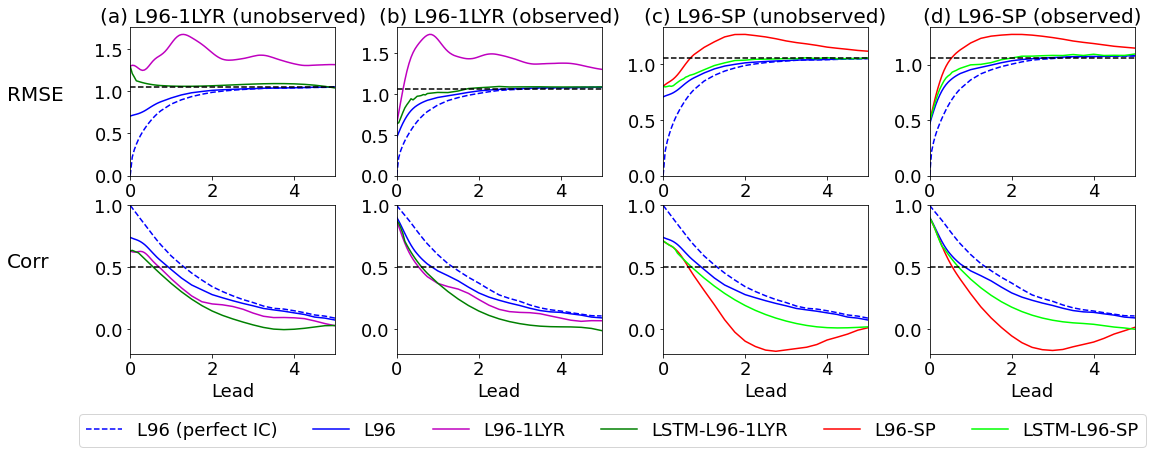

In [58]:
fontsize = 18
plt.rc("axes", titlesize=fontsize + 2)  # using a size in points
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)

fig, axs = plt.subplots(
    nrows=2,
    ncols=4,
    figsize=(18, 6),
)
x_left = 0
x_right = 5


axs[0, 0].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(rmse_perfect[lead_time_dims, :dim_I][:, hidden_dims], axis=1),
    "--",
    color="b",
)
axs[0, 0].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(rmse_perfect_DA[lead_time_dims, :dim_I][:, hidden_dims], axis=1),
    color="b",
)
axs[0, 0].plot(
    lead_time_steps[lead_time_dims_fine] * dt,
    np.mean(
        rmse_wrong_onelayer_DA[lead_time_dims_fine, :dim_I][:, hidden_dims],
        axis=1,
    ),
    color="m",
)
axs[0, 0].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        rmse_lstm_smooth_onelayer_DA[lead_time_dims, :dim_I][:, hidden_dims],
        axis=1,
    ),
    color="g",
)
# axs[0, 0].plot(
#     lead_time_steps[lead_time_dims] * dt,
#     np.mean(
#         rmse_lstm_onelayer_DA[lead_time_dims, :dim_I][:, hidden_dims], axis=1
#     ),
#     color="g",
# )
axs[0, 0].plot(
    [0, lead_time_steps[-1] * dt],
    [
        np.sqrt(np.var(true_state, axis=0))[:dim_I][hidden_dims].mean(),
        np.sqrt(np.var(true_state, axis=0))[:dim_I][hidden_dims].mean(),
    ],
    "--",
    color="black",
)

axs[0, 1].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(rmse_perfect[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    "--",
    color="b",
)
axs[0, 1].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(rmse_perfect_DA[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    color="b",
)
axs[0, 1].plot(
    lead_time_steps[lead_time_dims_fine] * dt,
    np.mean(
        rmse_wrong_onelayer_DA[lead_time_dims_fine, :dim_I][:, obs_dims],
        axis=1,
    ),
    color="m",
)
axs[0, 1].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        rmse_lstm_onelayer_DA[lead_time_dims, :dim_I][:, obs_dims], axis=1
    ),
    color="g",
)
axs[0, 1].plot(
    [0, lead_time_steps[-1] * dt],
    [
        np.sqrt(np.var(true_state, axis=0))[:dim_I][obs_dims].mean(),
        np.sqrt(np.var(true_state, axis=0))[:dim_I][obs_dims].mean(),
    ],
    "--",
    color="black",
)

axs[1, 0].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(corr_perfect[lead_time_dims, :dim_I][:, hidden_dims], axis=1),
    "--",
    color="b",
)
axs[1, 0].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(corr_perfect_DA[lead_time_dims, :dim_I][:, hidden_dims], axis=1),
    color="b",
)
axs[1, 0].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        corr_wrong_onelayer_DA[lead_time_dims, :dim_I][:, hidden_dims], axis=1
    ),
    color="m",
)
axs[1, 0].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        corr_lstm_smooth_onelayer_DA[lead_time_dims, :dim_I][:, hidden_dims],
        axis=1,
    ),
    color="g",
)
# axs[1, 0].plot(
#     lead_time_steps[lead_time_dims] * dt,
#     np.mean(
#         corr_lstm_onelayer_DA[lead_time_dims, :dim_I][:, hidden_dims], axis=1
#     ),
#     color="g",
# )

axs[1, 1].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(corr_perfect[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    "--",
    color="b",
    label="L96 (perfect IC)",
)
axs[1, 1].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(corr_perfect_DA[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    color="b",
    label="L96",
)
axs[1, 1].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        corr_wrong_onelayer_DA[lead_time_dims, :dim_I][:, obs_dims], axis=1
    ),
    color="m",
    label="L96-1LYR",
)
axs[1, 1].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        corr_lstm_smooth_onelayer_DA[lead_time_dims, :dim_I][:, obs_dims],
        axis=1,
    ),
    color="g",
    label="LSTM-L96-1LYR",
)

axs[0, 2].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(rmse_perfect[lead_time_dims, :dim_I][:, hidden_dims], axis=1),
    "--",
    color="b",
)
axs[0, 2].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(rmse_perfect_DA[lead_time_dims, :dim_I][:, hidden_dims], axis=1),
    color="b",
)
axs[0, 2].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        rmse_wrong_SPEKF_DA[lead_time_dims, :dim_I][:, hidden_dims], axis=1
    ),
    color="r",
)
axs[0, 2].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        rmse_lstm_SPEKF_DA[lead_time_dims, :dim_I][:, hidden_dims], axis=1
    ),
    color="lime",
)
axs[0, 2].plot(
    [0, lead_time_steps[-1] * dt],
    [
        np.sqrt(np.var(true_state, axis=0))[:dim_I][hidden_dims].mean(),
        np.sqrt(np.var(true_state, axis=0))[:dim_I][hidden_dims].mean(),
    ],
    "--",
    color="black",
)

axs[0, 3].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(rmse_perfect[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    "--",
    color="b",
)
axs[0, 3].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(rmse_perfect_DA[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    color="b",
)
axs[0, 3].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(rmse_wrong_SPEKF_DA[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    color="r",
)
axs[0, 3].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(rmse_lstm_SPEKF_DA[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    color="lime",
)
axs[0, 3].plot(
    [0, lead_time_steps[-1] * dt],
    [
        np.sqrt(np.var(true_state, axis=0))[:dim_I][obs_dims].mean(),
        np.sqrt(np.var(true_state, axis=0))[:dim_I][obs_dims].mean(),
    ],
    "--",
    color="black",
)

axs[1, 2].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(corr_perfect[lead_time_dims, :dim_I][:, hidden_dims], axis=1),
    "--",
    color="b",
)
axs[1, 2].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(corr_perfect_DA[lead_time_dims, :dim_I][:, hidden_dims], axis=1),
    color="b",
)
axs[1, 2].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        corr_wrong_SPEKF_DA[lead_time_dims, :dim_I][:, hidden_dims], axis=1
    ),
    color="r",
)
axs[1, 2].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        corr_lstm_smooth_SPEKF_DA[lead_time_dims, :dim_I][:, hidden_dims],
        axis=1,
    ),
    color="lime",
)

axs[1, 3].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(corr_perfect[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    "--",
    color="b",
    label="L96 (perfect IC)",
)
axs[1, 3].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(corr_perfect_DA[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    color="b",
    label="L96",
)
axs[1, 3].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(corr_wrong_SPEKF_DA[lead_time_dims, :dim_I][:, obs_dims], axis=1),
    color="r",
    label="L96-SP",
)
axs[1, 3].plot(
    lead_time_steps[lead_time_dims] * dt,
    np.mean(
        corr_lstm_smooth_SPEKF_DA[lead_time_dims, :dim_I][:, obs_dims], axis=1
    ),
    color="lime",
    label="LSTM-L96-SP",
)


axs[0, 0].set_title("(a) L96-1LYR (unobserved)")
axs[0, 1].set_title("(b) L96-1LYR (observed)")
axs[0, 2].set_title("(c) L96-SP (unobserved)")
axs[0, 3].set_title("(d) L96-SP (observed)")

axs[0, 0].text(-3, 0.9, "RMSE", fontsize=fontsize + 2)
axs[1, 0].text(-3, 0.5, "Corr", fontsize=fontsize + 2)
handles1, labels1 = axs[1, 1].get_legend_handles_labels()
handles2, labels2 = axs[1, 3].get_legend_handles_labels()
labels = labels1 + labels2[-2:]
handles = handles1 + handles2[-2:]
axs[1, 0].legend(handles, labels, ncol=6, bbox_to_anchor=(5, -0.35))
for i in range(4):
    axs[0, i].set_ylim(bottom=0)
    axs[1, i].set_ylim(top=1)
    axs[0, i].set_xlim([0, 5])
    axs[1, i].set_xlim([0, 5])
    axs[1, i].set_ylim([-0.2, 1])
    axs[1, i].set_xlabel("Lead", fontsize=fontsize)
    axs[1, i].plot(
        [0, lead_time_steps[-1] * dt], [0.5, 0.5], "--", color="black"
    )
    axs[1, i].locator_params(axis="y", nbins=3)
plt.subplots_adjust(wspace=0.3)
savefig(
    fig,
    osp.join(
        output_path,
        model + "_RMSE_Corr_AVE.pdf",
    ),
)